In [20]:
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pytesseract as pyt
import pandas as pd
from scipy.stats import mode
from sklearn.cluster import DBSCAN
import os
pyt.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Local imports

In [2]:
annoying_book = cv.imread("Source data/Book.png")
annoying_wreath = cv.imread("Source data/wreath.png")
period_image = cv.imread("Source data/Period.png")

# Display

A function used for displaying images in-line rather than as a separate window. Input is a picture

In [3]:
# function display copied shamelessly in its entirety
def display(im_data):
    dpi = 80

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()




def display_items(items: list):
    for item in items:
        display(item)


# Preprocessing - raw image

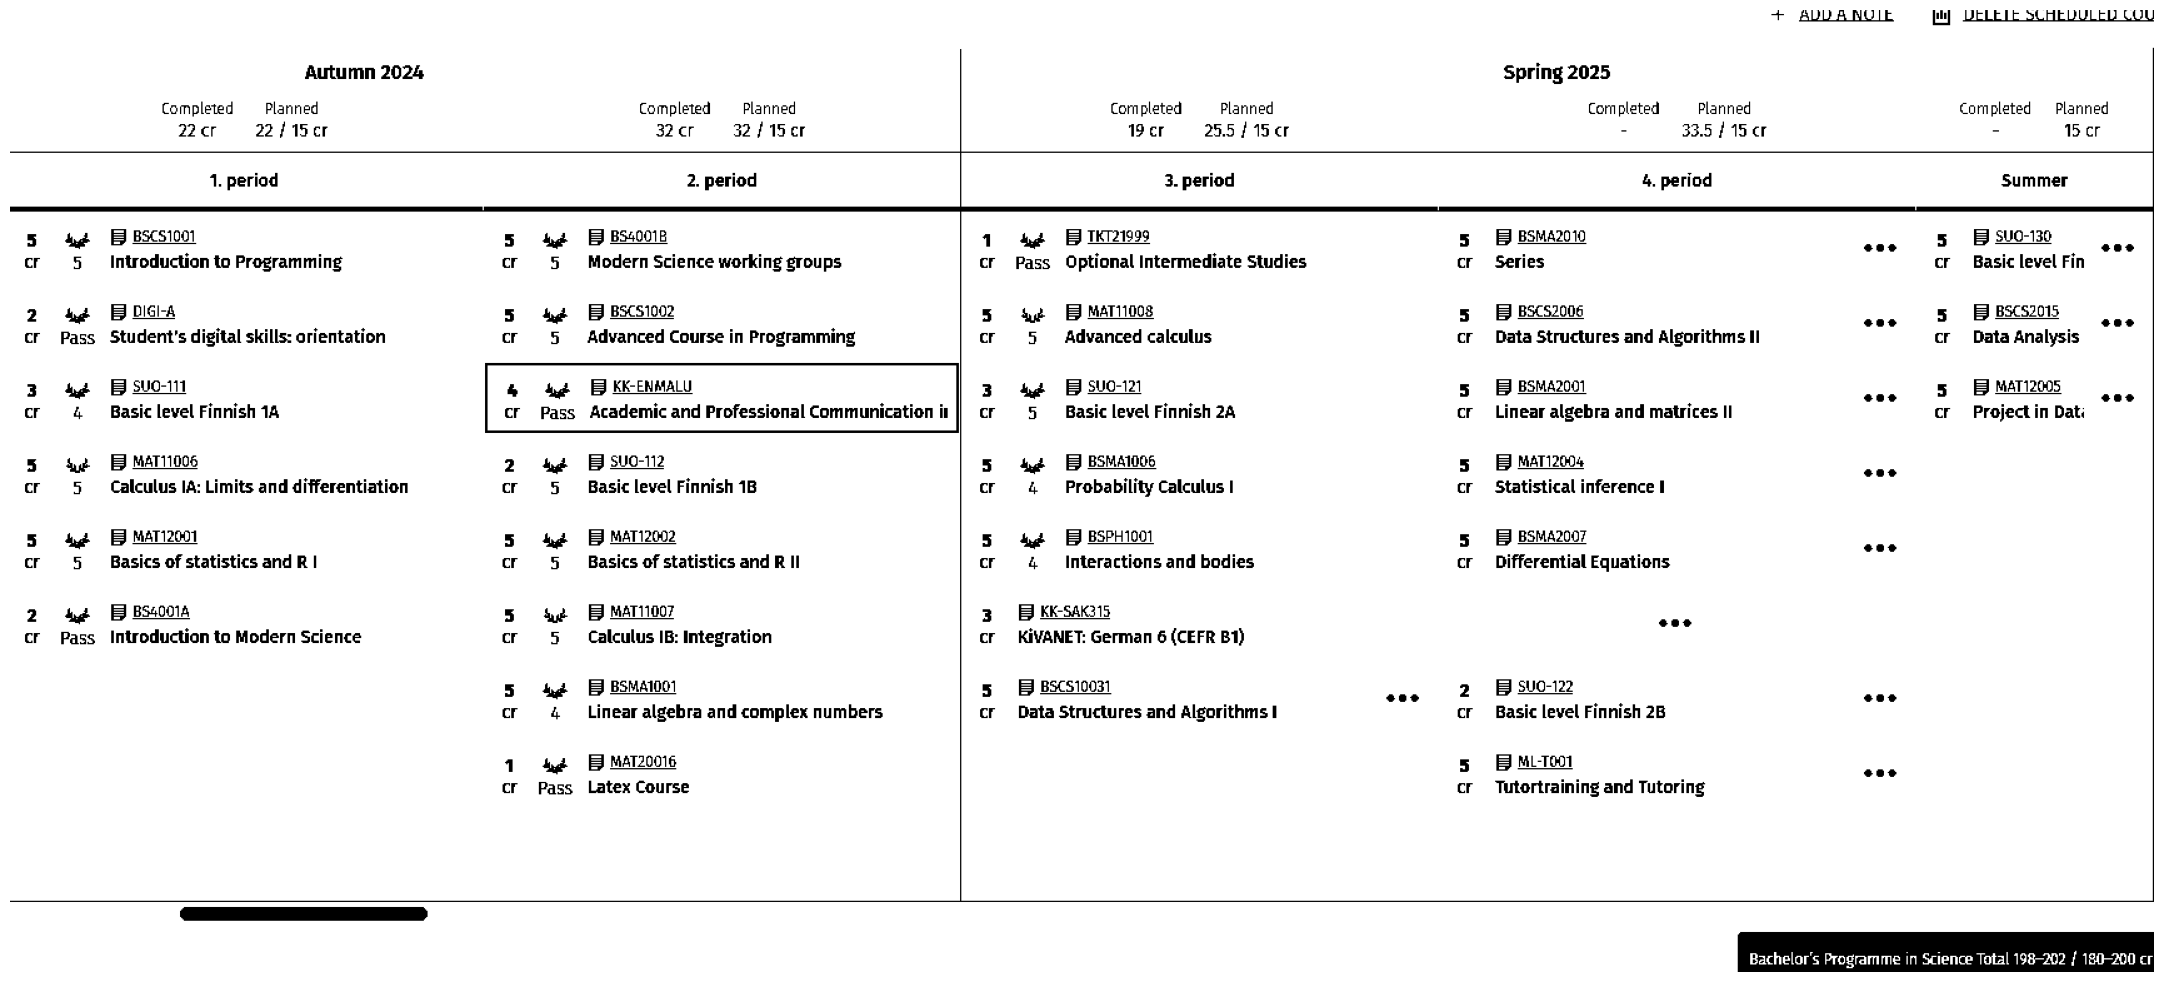

In [4]:
# converts image to binary

img = cv.imread("Testing/2.png")
def to_bin(im):
    if len(im.shape) == 3:
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    _, im_bw = cv.threshold(im, 185, 255, cv.THRESH_BINARY)
    return im_bw

im_bw = to_bin(img)

display(im_bw)

In [5]:

# some objects are messing up text recognition. the function below
# removes them

def remove_object(img, template, threshold=0.72, scales=np.linspace(0.5, 1.4, 30)):
    bin = to_bin(img)

    #checks a range of scales
    for scale in scales:
        # Resize the template
        temp_resized = cv.resize(template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)
        temp_resized = to_bin(temp_resized)
        th, tw = temp_resized.shape[:2]
        if th > bin.shape[0] or tw > bin.shape[1]:
            continue  # skip if resized template is bigger than image

        # Template matching
        res = cv.matchTemplate(bin, temp_resized, cv.TM_CCOEFF_NORMED)
        loc = np.where(res >= threshold)

        for pt in zip(*loc[::-1]):
            cv.rectangle(img, pt, (pt[0] + tw, pt[1] + th), (255,255,255), -1)

    return img

In [6]:
# divides image into three: first row contains years, second contains periods,
# and third contains courses

def split_image(img, template, threshold=0.74, scales=np.linspace(0.5, 1.4, 30)):
    bin = to_bin(img)
    all_detected = np.array([])
    
    for scale in scales:
        # Resize the template
        temp_resized = cv.resize(template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA)
        temp_resized = to_bin(temp_resized)
        th, tw = temp_resized.shape[:2]
        if th > bin.shape[0] or tw > bin.shape[1]:
            continue  # skip if resized template is bigger than image

        # Template matching
        res = cv.matchTemplate(bin, temp_resized, cv.TM_CCOEFF_NORMED)
        loc = np.where(res >= threshold)

        for pt in zip(*loc[::-1]):
            all_detected = np.append(all_detected,[pt[1],pt[1] + th])
    all_detected = all_detected.reshape((-1,2)).astype(int)
    modes = mode(all_detected, axis=0).mode

    # guaranteed that mode only has 2 different values, so hard coding this in is okay
    images = [img[:modes[0],:,:],img[modes[0]:modes[1],:,:],img[modes[1]:,:,:]]
    return images

In [7]:
# function copied with continued lack of shame 
# removes the lines under course codes. Hard for pytesseract to
# read underlined words
def remove_underlines(img):
    gray_dst = to_bin(img)
    edges = cv.Canny(img, 50, 150, apertureSize = 3)
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (15,1))

    # Using morph open to get lines inside the drawing
    opening = cv.morphologyEx(edges, cv.MORPH_OPEN, horizontal_kernel)
    cnts = cv.findContours(opening, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    mask = np.uint8(gray_dst)
    mask = np.zeros(gray_dst.shape, np.uint8)
    for c in cnts:
        cv.drawContours(mask, [c], -1, (255,255,255),2)

    # Second inpaint
    return cv.inpaint(img, mask, 3, cv.INPAINT_TELEA)


In [8]:
# function from stack overflow, makes as much sense to me as Chinese (I do not speak Chinese)
# takes away pointless lines and circles, for improved contour and detection
def remove_lines_and_circles(img):
    thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (25,1))
    detected_lines = cv.morphologyEx(thresh, cv.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv.findContours(detected_lines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv.drawContours(img, [c], -1, (255,255,255), 2)
    repair_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1,6))
    img = (255 - cv.morphologyEx(255 - img, cv.MORPH_CLOSE, repair_kernel, iterations=1))

    blurred = cv.GaussianBlur(img, (5, 5), 0)
    binary = cv.threshold(blurred, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    contours = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    for c in contours:
        area = cv.contourArea(c)
        if area < 1:  # skip noise
            continue
        perimeter = cv.arcLength(c, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        if 0.92 < circularity < 1.2:  # near-perfect circles
            cv.drawContours(img, [c], -1, (255, 255, 255), -1)  # fill with white

    return img

# check how necessary this is

In [9]:
# remove noise
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv.dilate(image, kernel, iterations=2)
    kernel = np.ones((1, 1), np.uint8)
    image = cv.erode(image, kernel, iterations=2)
    image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    image = cv.medianBlur(image, 3)
    return image

In [10]:
# make lines thicker and thinner

# thicker
def thick_line(img):
    img = cv.bitwise_not(img)
    kernel = np.ones((3,3),np.uint8)
    img = cv.dilate(img, kernel, iterations=7)
    img = cv.bitwise_not(img)
    return img

# thinner
def thin_line(img):
    img = cv.bitwise_not(img)
    kernel = np.ones((3,3),np.uint8)
    img = cv.erode(img, kernel, iterations=1)
    img = cv.bitwise_not(img)
    return img

In [11]:
# blurs images to improve contour detection 
# for splitting periods

def blur_img(im):
    return cv.GaussianBlur(im,(17,17),0)

In [12]:
# blurs the values further to form boxes for periods

def blow_up(im, blur_values):
    thresh = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)[1]
    kernel = cv.getStructuringElement(cv.MORPH_RECT,blur_values)

    return cv.dilate(thresh,kernel,iterations=1)


In [13]:
# separates image based on contours

def bounding_boxes(im, og_im, h_cap=40, w_cap=40):
    cnts = cv.findContours(im, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=lambda x: cv.boundingRect(x)[0])
    roi = []
    x_pos = []
    img_cop = og_im.copy()
    img_cop = remove_object(img_cop, annoying_book)
    img_cop = remove_object(img_cop, annoying_wreath)
    img_cop = remove_underlines(img_cop)
    img_cop2 = img_cop.copy()
    for c in cnts:
        x, y, w,h = cv.boundingRect(c)
        if h > h_cap and w > w_cap:
            x_pos.append(x)
            roi.append(img_cop[y:y+h,x:x+w])
            cv.rectangle(img_cop2,(x,y),(x+w,y+h), (36,255,12), 2)
    return img_cop2, roi, x_pos

In [14]:
# takes a raw image and spits out relevant boxes
# can be directly used to obtain periods from image

def divide(im, dilated_bounds,h=40, w=40):
    im_bin = to_bin(im)
    fluff_removed = remove_lines_and_circles(im_bin)
    blurred = blur_img(fluff_removed)
    dilated = blow_up(blurred, dilated_bounds)
    _, periods, x_pos = bounding_boxes(dilated, im,h,w)
    return periods, x_pos

# Processing - Periods to courses

In [15]:
# Increase DPI to improve text detection

def dpi_increase(image, scale_factor):
    # Resize image by 2x or 3x to simulate higher DPI
    height, width = image.shape[:2]
    image = cv.resize(image, (width * scale_factor, height * scale_factor), interpolation=cv.INTER_CUBIC)


    data = pyt.image_to_data(image, output_type="dict")

    heights = []
    for i in range(len(data['text'])):
        if data['text'][i].isupper():
            heights.append(data['height'][i])

    if heights:
        avg_cap_height = sum(heights) / len(heights)

        # Scale image if too small
        if avg_cap_height < 30:
            scale = 30.0 / avg_cap_height
            h, w = image.shape[:2]
            image = cv.resize(image, (int(w * scale), int(h * scale)), interpolation=cv.INTER_CUBIC)
    return image

# img = dpi_increase(img, 4)

# display(img)


# for processed[1][1][2]:
# does it correctly, but the proceeds to also give the ENTIRE thing
# add in a safeguard so that if there are more than two codes present,
# then it checks to see if there are any duplicates and then does stuff
# sum like that


In [16]:
# divides a period box to course boxes

def divide_to_courses(img,dilated_bounds=(10,28)):
    scale = 5
    courses, x_pos = divide(img, dilated_bounds)
    x_pos = [i*scale for i in x_pos]
    hd = []
    for course in courses:
        course_hd = dpi_increase(course,scale)
        course_bin = to_bin(course_hd)
        hd.append(course_bin)

    return hd, x_pos


# Add in some "did you mean" safeguards: processed[3][2] returns
# odern science... and ...complex nwnbers

# Processing - Courses to database

In [17]:
# processes text to form

def text_processing(courses, x_pos, course_pos, course_df=pd.DataFrame(columns=["Code","Name", "Period"])):

    for i, img in enumerate(courses):
        text = pyt.image_to_data(img, output_type="data.frame")
        text = text.dropna(subset=["text"])
        if len(text) == 0:
            continue
        #below mask and operations remove all empty rows
        mask = text["text"].str.match(r"^\s+$|^\s*Pass\s*$")
        # mask = text["text"].str.match(r"^\s+$")
        text = text[~mask]
        text_final = text[(text.conf > 10)].reset_index(drop=True) 
        text_final["text"] = text_final["text"].str.replace("|","I", regex=False)
        # play with the confidence value above. Too high and it risks cutting words out that are not fully in
        # the picture, and too low and it might include weird symbols
        #below mask finds all course codes
        matches = text_final["text"].str.match(r"^[A-Z]{2,4}-?[A-Z0-9]{0,6}$")
        # skips if there is no course code in the image
        # could be a good place to add in period finderz
        if not matches.any():
            continue # LATER MAKE THIS SO THAT ALL THE PICS WITH NO MATCHES ARE STORED,
        # SO THAT MISTAKES CAN BE BETTER TAKEN CARE OF
        # Also, SUO gets read as SUQ sometimes. I couldnt find any instances of Q
        # in course codes so it might be fine to just replace all Qs
        text_final["flag"] = matches.cumsum()
        course_word = text_final[~matches]
        course_name = course_word.groupby("flag")["text"].apply(" ".join).rename("Name")
        course_name = course_name.str.replace(r"^\s*\d+\s*","", regex=True)
        course_code = text_final[matches][["text", "flag", "left"]].rename(columns={"text": "Code", "left": "X Position"})
        course_code["X Position"] = course_code["X Position"] + x_pos + course_pos[i]
        course_code["Code"] = course_code["Code"].str.replace("Q", "O",regex=False)
        # this last line can be moved out, and instead just 
        # pd.merge(course_code, course_name, on="flag")[["Code", "Name"]] can be returned
        course_df = pd.concat([course_df,pd.merge(course_code, course_name, on="flag")[["Code", "Name", "X Position"]]])

    return course_df.reset_index(drop=True)
    

In [28]:
def locate_period(course_df, period_img):
    #process period text
    period_img, x_pos = divide(period_img, (10,10),2,2)
    x_pos = [i*5 for i in x_pos]
    period_text = pd.DataFrame()
    for i, img in enumerate(period_img):
        img = dpi_increase(img,5)
        img = to_bin(img)
        img_text = pyt.image_to_data(img, output_type="data.frame")
        img_text["Position"] = img_text["left"] + x_pos[i]
        if period_text.empty:
            period_text = img_text
        else:
            period_text = pd.concat([period_text, img_text])
    period_text = period_text[(period_text.conf > 10)]
    period_text = period_text.dropna(subset=["text"])
    period_text["text"] = period_text["text"].str.replace("Swumer","Summer", regex=False)


    # group each period
    period_grouper = DBSCAN(eps=200, min_samples=1)
    period_grouper.fit(np.array(period_text["Position"]).reshape(-1,1)) 
    period_text["Labels"] = period_grouper.labels_
    periods = period_text.groupby("Labels")["text"].apply(" ".join).reset_index().rename(columns={"text": "Period"})

    # group course to period
    # add in a safeguard to check what happens if len(labels)
    # of courses and period dont match
    course_eps = min(x_pos)/2 + 0.01
    course_grouper = DBSCAN(eps=course_eps, min_samples=1)
    course_grouper.fit(np.array(course_df["X Position"]).reshape(-1,1))
    course_df["Labels"] = course_grouper.labels_
    course_df = pd.merge(course_df,periods, on="Labels")[["Code","Name","Period"]]

    return course_df

In [19]:
# full function
    #make all these values - eps=10, scale=5, (35,7) work with all 
    #image scales

def img_to_database(im):
    courses_df = pd.DataFrame(columns=["Code","Name", "X Position"])
    imgs = split_image(im, period_image)
    periods,x_pos = divide(imgs[2],(1,100))
    # even if no dpi increase on first one, we still need to scale
    # up to account for the scaling of the in divide_to_courses
    x_pos = [i*5 for i in x_pos]
    for i, period in enumerate(periods):
        courses, course_pos = divide_to_courses(period)
        courses_df = text_processing(courses, x_pos[i], course_pos, courses_df)

    courses_df = locate_period(courses_df, imgs[1])
    return courses_df

Where are the main problems when it comes to character recognition?

1. Try and change to EasyOCR, it might be better
2. T -> 1
3. O -> Q

In [29]:
output_path = 'Output/output.csv'
dfs = []
for i in range(1,7):
    df = img_to_database(cv.imread(f"Testing/{i}.png"))
    df.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    dfs.append(df)
    print(f"Finished image {i}")

Finished image 1
Finished image 2
Finished image 3
Finished image 4
Finished image 5
Finished image 6
